In [1]:
import numpy as np
import pandas as pd 
import gzip
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
with gzip.open("../00.data/preprocesado/meneame_procesado.pkl.gz", "rb") as f:
    df = pickle.load(f)

In [3]:
# df para clustering y modelos predictivos posteriores
df_clustering = df[['meneos', 'clicks', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments', 'category']]

# df para ver KMeans y clustering
df_numeric = df[['meneos', 'clicks', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments']]

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [5]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

Elbow  method : definir cuantos clusters necesitamos

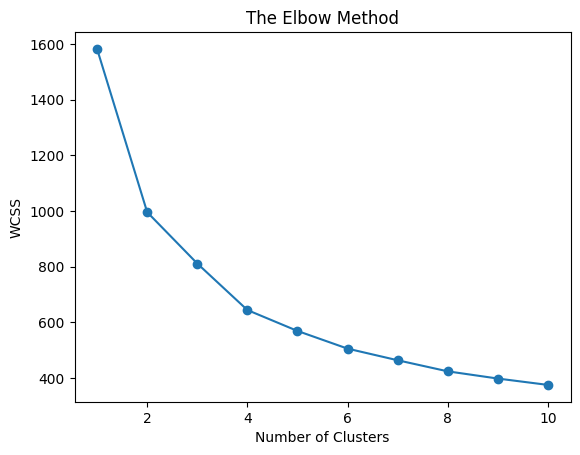

In [6]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

De este grafo mostrando within-cluster sum of squares por numero de clusters, elbow e ve aproximadamente en n_cluster = 3 o 4. Asi que ahora vamos a hacer KMeans con n=3 y con n=4

In [7]:
kmeans_3 = KMeans(n_clusters=3, init="k-means++", max_iter=300, n_init=10, random_state=42)
labels_3 = kmeans_3.fit_predict(df_scaled)

kmeans_4 = KMeans(n_clusters=4, init="k-means++", max_iter=300, n_init=10, random_state=42)
labels_4 = kmeans_4.fit_predict(df_scaled)

Ahora haciendo silhouette score para ver cual de los dos esta mejor (n=3 o n=4)

In [8]:
from sklearn.metrics import silhouette_score

# Compute silhouette score for both cases
silhouette_3 = silhouette_score(df_scaled, labels_3)
silhouette_4 = silhouette_score(df_scaled, labels_4)

print(f"Silhouette Score for 3 Clusters: {silhouette_3:.3f}")
print(f"Silhouette Score for 4 Clusters: {silhouette_4:.3f}")

Silhouette Score for 3 Clusters: 0.531
Silhouette Score for 4 Clusters: 0.370


In [9]:
#elegir silhouette score que esta mas alta y eso seria numero de clusters
#hacer PCA para poder visualizar data en 2D porque no se puede hacerlo con 7 dimensiones

In [10]:
# KModes incluyendo categoría?

In [11]:
df_numeric.loc[:, "cluster_3"] = labels_3

C:\Users\Jordi\AppData\Local\Temp\ipykernel_2908\1428604759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numeric.loc[:, "cluster_3"] = labels_3


In [12]:
df_numeric["cluster_3"].value_counts()

cluster_3
1    234301
0     44340
2      8922
Name: count, dtype: int64

In [13]:
df_numeric.groupby("cluster_3").mean()

,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments
cluster_3,,,,,,,
0,1211.928259,4785.819734,543.691069,401.089220,5.494587,810.839039,108.159720
1,377.836087,3072.752267,508.405756,172.364382,2.705699,205.471705,65.244916
2,669.724053,6494.435553,469.830868,261.586416,41.574535,408.137637,144.302623


In [14]:
# cluster 0 es menos numeroso
# media mas alta de clicks, muchos anonymous_votes y comments, y el grupo con mayor votos negativos

# cluster 1 es el más numeroso
# menor número de meneos y clicks, karma medio, positive_votes y negative_votes más bajos, menor número de comentarios

# cluster 2
# meneos más alto, clicks medios, karma, positive_votes y anonymous_votes más altos, y bastantes comments

In [15]:
# Cluster 0 → Noticias polémicas o virales con gran interacción
# Cluster 0 parece representar noticias polémicas, generando muchos clicks, comentarios y votos negativos

# Cluster 1 → Noticias estándar, sin ser virales ni polémicas.
# Cluster 1 es el comportamiento estándar de la mayoría de las noticias

# Cluster 2 → Noticias muy populares en la comunidad con alto impacto
# Cluster 2 agrupa noticias muy populares en la comunidad, con muchos meneos y karma alto

In [16]:
df_clustering.loc[:, "cluster_3"] = labels_3

C:\Users\Jordi\AppData\Local\Temp\ipykernel_2908\3181467307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustering.loc[:, "cluster_3"] = labels_3


In [18]:
df_clustering.head()

,meneos,clicks,karma,positive_votes,negative_votes,anonymous_votes,comments,category,cluster_3
0,115,651,410,57,1,58,30,Política y Sociedad,1
1,77,982,362,50,2,27,24,Entretenimiento y Cultura,1
2,97,761,369,50,0,47,70,Política y Sociedad,1
3,141,505,352,77,1,64,53,Política y Sociedad,1
4,213,335,349,99,1,114,28,Política y Sociedad,1


In [19]:
with gzip.open("../00.data/clustering/df_clustering.pkl.gz", "wb") as f:
    pickle.dump(df_clustering, f, protocol=pickle.HIGHEST_PROTOCOL)

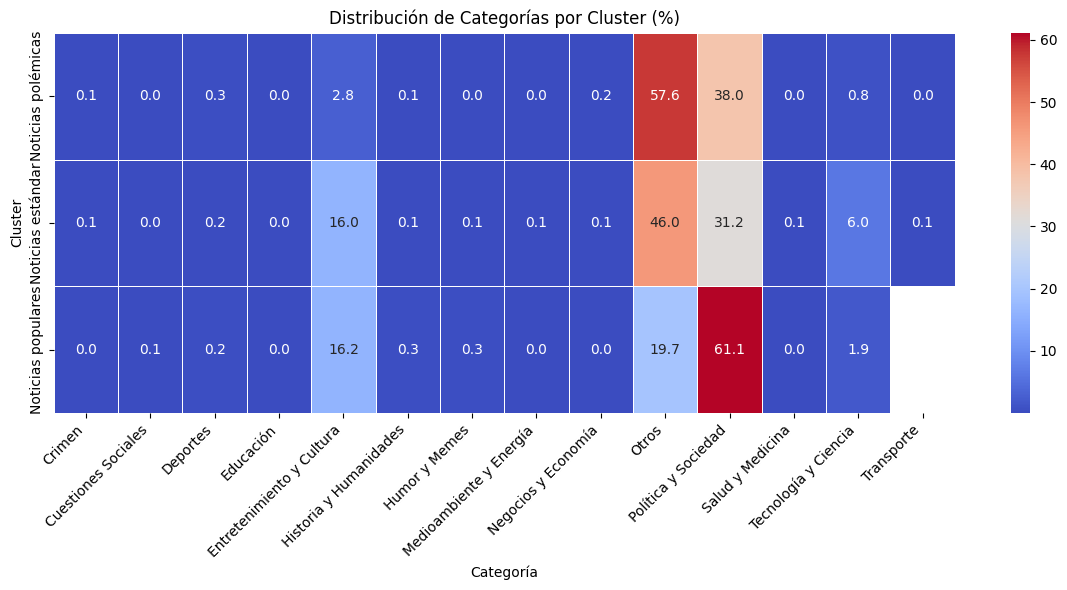

In [20]:
# Definir nombres de los clusters
cluster_names = {
    0: "Noticias polémicas",
    1: "Noticias estándar",
    2: "Noticias populares"
}

# Contar cuántas noticias de cada categoría hay en cada cluster
cluster_category_counts = df_numeric.join(df['category']).groupby(["cluster_3", "category"], observed=True).size().unstack()

# Normalizar por filas para ver proporciones en cada cluster
cluster_category_pct = cluster_category_counts.div(cluster_category_counts.sum(axis=1), axis=0) * 100

# Renombrar los índices de los clusters
cluster_category_pct.index = cluster_category_pct.index.map(cluster_names)

# Gráfico de calor para visualizar la distribución
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_category_pct, cmap="coolwarm", annot=True, fmt=".1f", linewidths=0.5)

plt.title("Distribución de Categorías por Cluster (%)")
plt.ylabel("Cluster")
plt.xlabel("Categoría")
plt.xticks(rotation=45, ha="right", fontsize=10)

plt.tight_layout()
plt.show()


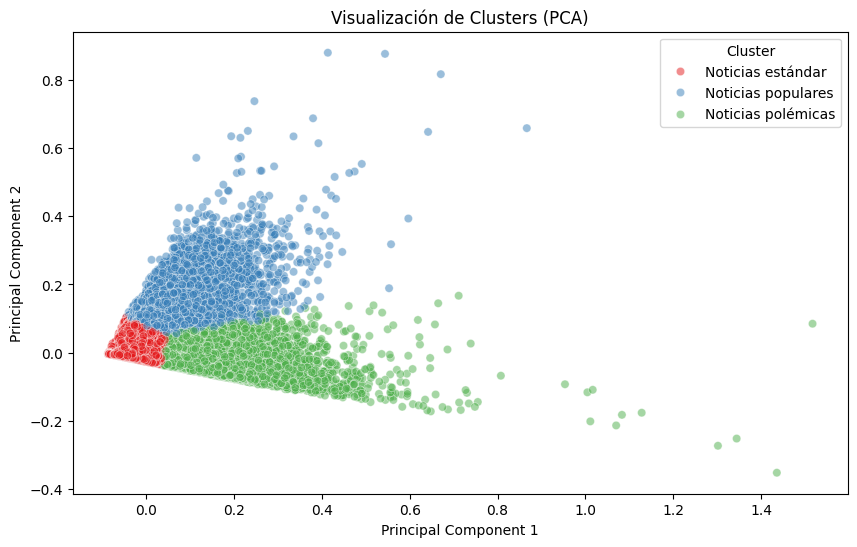

In [22]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reducimos a 2 dimensiones con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Convertimos a DataFrame para graficar
df_plot = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_plot["Cluster"] = pd.Series(labels_3).map(cluster_names)

# Gráfico de dispersión con nombres personalizados
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="Set1", alpha=0.5)
plt.title("Visualización de Clusters (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()